# AUTO-PLATE-RECOGNITION
#### UCLA CS145 - Professor Si Si
#### TEAM NAME: Deep Learners
----
#### TEAM MEMBERS:
Caleb Lee   UID: 305-330-193    Email: bkcaleb45@g.ucla.edu 

Dylan Phe	UID: 505-834-475	Email: dylanphe@g.ucla.edu

Kevin Wang	UID:  305-503-382      Email: kwang1083@g.ucla.edu

---

## I. Importing the necessary packages

In [3]:
import os
import random
import csv
import numpy as np
import pandas as pd
import keras
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import gaussian_filter

## II. Preparing and Pre-Procesing the Dataset

### 2.(a). Loading and Visualizing the dataset 

The dataset consists of 4,337 images of license plates from all 51 U.S. states, which was obtained from the following source: https://www.kaggle.com/code/tolgadincer/us-license-plates-data-quick-overview/input?select=data. We then organized this data into a table format of dimensions 4,337x2(file_list.csv). Each entry in the table contains two attributes, namely "Label" and "Image", which serve to identify each image file along with its corresponding label. In addition, we also split them into the training dataset(train_data.csv) and the testing dataset(test_data.csv). The process to achieve this is as follows:

In [19]:
# Directory path
dataset_path = 'dataset'

# CSV file path
csv_file = 'file_list.csv'
test_data_file = 'test_data.csv'
train_data_file = 'train_data.csv'

# Function to get the file list in a directory
def get_file_list(directory):
    file_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_list.append(file)
    return file_list

# Check if the CSV files already exist
csv_file_exists = os.path.exists(csv_file)
test_data_file_exists = os.path.exists(test_data_file)
train_data_file_exists = os.path.exists(train_data_file)

# Generate CSV file if it doesn't exist
if not csv_file_exists:
    # Get directory list in /dataset
    directories = [directory for directory in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, directory))]

    # Open the CSV file in write mode
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)

        # Iterate through directories
        for directory in directories:
            # Get file list in the current directory
            file_list = get_file_list(os.path.join(dataset_path, directory))

            # Write file list to CSV
            for file_name in file_list:
                writer.writerow([directory, file_name])

    print("CSV file generated successfully.")
else:
    print("CSV file already exists. Skipping generation.")

# Read the data from the original CSV file if it exists
data = []
if csv_file_exists:
    with open(csv_file, mode='r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip the header row
        for row in reader:
            data.append(row)

    # Shuffle the data randomly
    random.shuffle(data)

    # Calculate the split index
    split_index = int(len(data) * 9 / 10)

    # Split the data into test and train sets
    train_data = data[:split_index+1]
    test_data = data[split_index:]

    # Write test data to CSV if it doesn't exist
    if not test_data_file_exists:
        with open(test_data_file, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Label', 'Image'])  # Header
            writer.writerows(test_data)
        print("Test data CSV file generated successfully.")
    else:
        print("Test data CSV file already exists. Skipping generation.")

    # Write train data to CSV if it doesn't exist
    if not train_data_file_exists:
        with open(train_data_file, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Label', 'Image'])  # Header
            writer.writerows(train_data)
        print("Train data CSV file generated successfully.")
    else:
        print("Train data CSV file already exists. Skipping generation.")

    print("Data separation completed successfully.")


CSV file already exists. Skipping generation.
Test data CSV file generated successfully.
Train data CSV file generated successfully.
Data separation completed successfully.


After the csv files were created, we utilized pandas to read both the train_data.csv and the test_data.csv and converted them into train and test dataframes as shown below. The training dataframe should contain 3935 rows whereas the testing dataset should contain 438 rows. The proportion of the split is 9:1.

In [20]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')
print(f"Training data = {train.shape}")
print(f"Testing data = {test.shape}")
train

Training data = (3935, 2)
Testing data = (438, 2)


,Label,Image
0,RhodeIsland,7be78ef117a51f.jpg
1,California,e8cb56d705e3fc.jpg
2,Pennsylvania,d091dd62d2a763.jpg
3,Missouri,24b16cf22a23d5.jpg
4,Missouri,576e36ee8e44b7.jpg
...,...,...
3930,Indiana,5b77f2dd545f8c.jpg
3931,Alaska,a12bf475998dda.jpg
3932,Oklahoma,a5d855a8224501.jpg
3933,Michigan,fc3095ddc9b064.jpg


Given the tables above, we can easily obtain the image files and its corresponding true labels from the dataframes while also being able to distinguish between the two for the purposes of trainings and making predictions. The code below is written and executed as a mean to visualize our dataset.

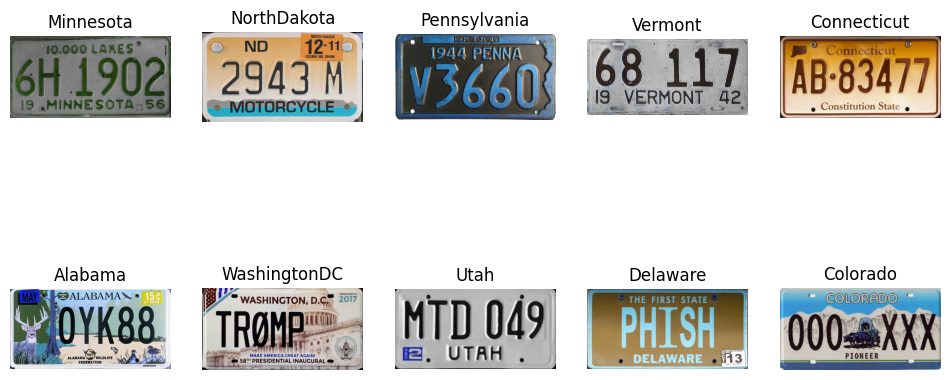

In [42]:
random.seed(1)
sample = random.sample(list(train.index), 10)

fig, ax = plt.subplots(2, 5, figsize=(12, 6))
ax = ax.flatten()

for i, idx in enumerate(sample):
    path = os.path.join('dataset', train.loc[idx, 'Label'], train.loc[idx, 'Image'])
    img = cv2.imread(path)
    ax[i].imshow(img)
    ax[i].set_title(train.loc[idx, 'Label'])
    ax[i].axis('off')
plt.show()

Below specify the steps that we take to pre-process the images data. First, we applied histogram equalization to imporces the contrast of the input images. Then, we also apply anisotropic diffusion to denoise any noisy images. In addition, we also split the images into the top and the bottom parts as they are the common locations where the State's names are placed on the license plate. Finally, we invert the dark and the light part of the image so that the letter appear clearer on the images.

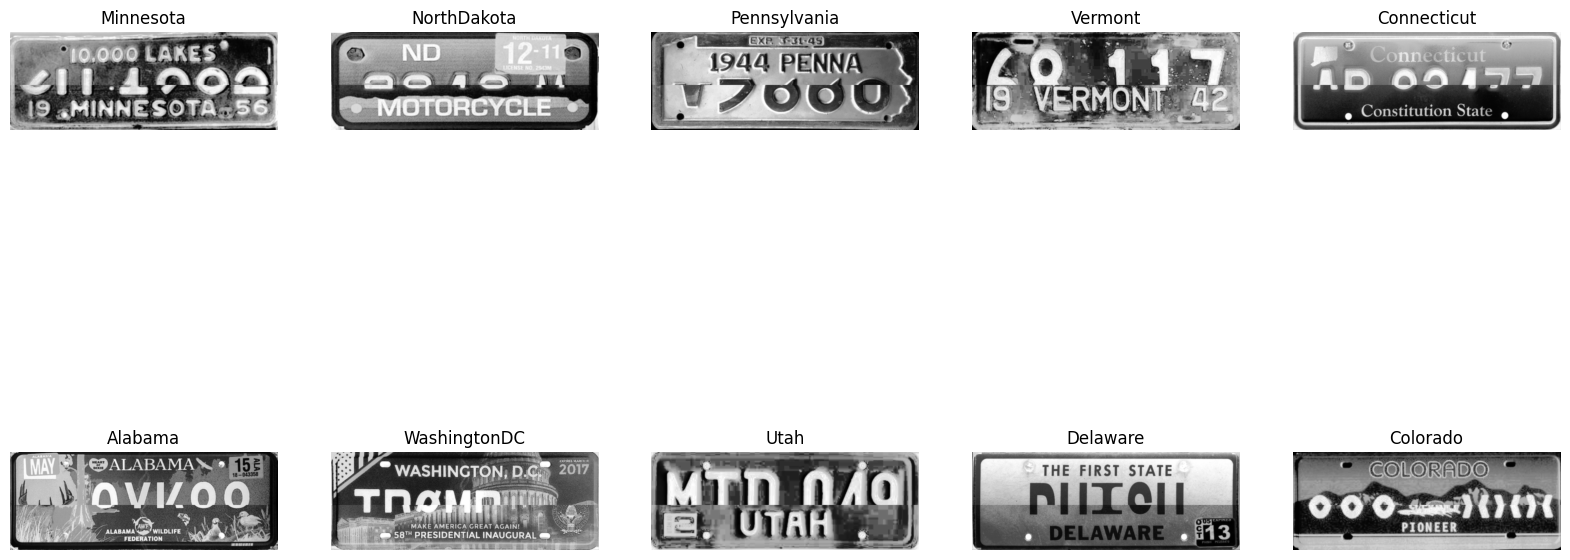

In [44]:
random.seed(1)
sample = random.sample(list(train.index), 10)

fig, ax = plt.subplots(2, 5, figsize=(20, 10))
ax = ax.flatten()

for i, idx in enumerate(sample):
    path = os.path.join('dataset', train.loc[idx, 'Label'], train.loc[idx, 'Image'])
    img = cv2.imread(path)
    img = cv2.resize(img, (1000, 500))
    
    # Convert the image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply histogram equalization
    equalized_img = cv2.equalizeHist(gray_img)
    
    # Apply anisotropic diffusion using gaussian_filter on equalized image
    denoised_img = gaussian_filter(equalized_img, sigma=1)

    # Calculate the height of the image
    height = img.shape[0]
    
    # Cut the image in half
    top_img = denoised_img[0:int((height/2.5)), :]
    bottom_img = denoised_img[int(2*(height/3)):height, :]
    
    # Calculate the average brightness of the top image
    taverage_brightness = np.mean(top_img)
    baverage_brightness = np.mean(bottom_img)
    
    # Define threshold values for brightness adjustment
    dark_threshold = 60  # Adjust this value to determine what is considered dark
    
    if taverage_brightness < dark_threshold:
        # Invert the dark and light parts of the image
        t_img = cv2.bitwise_not(top_img)
    else:
        t_img = top_img
        
    if baverage_brightness < dark_threshold:
        # Invert the dark and light parts of the image
        b_img = cv2.bitwise_not(bottom_img)
    else:
        b_img = bottom_img
        

    # Concatenate the top and bottom images horizontally
    concat_img = np.concatenate((t_img, b_img), axis=0)
    concat_img = cv2.bitwise_not(concat_img)
    
    ax[i].imshow(concat_img, cmap='gray')
    ax[i].set_title(train.loc[idx, 'Label'])
    ax[i].axis('off')

plt.show()

### 2.(b) Pre-Processing and Spliting the dataset into the training, validation, and test datasets

To prepare our dataset for the training and the prediction stages, we parse the images and append them to their corresponding row within dataframes. However, since there are many data to process and some pcs might not have sufficient memory, we instead split them into eight splits and process them one by one. 

In [39]:
def split_data(data, parts):
    # Split the data into the specified number of parts
    splits = np.array_split(data, parts)

    images = []
    labels = []

    # Loop through the splits
    for split in splits:
        # Parse the images in this split
        split_images, split_labels = parse_images(split)

        # Append the parsed images and labels to the lists
        images.append(split_images)
        labels.append(split_labels)

    # Concatenate the splits to get the final datasets
    images = np.concatenate(images)
    labels = np.concatenate(labels)

    return images, labels

def parse_images(data):
    images = []
    labels = []

    # Loop through the CSV entries and load each image
    for index, row in data.iterrows():
        img_path = 'dataset' + '/' + row['Label'] + '/' + row['Image']
        img = cv2.imread(img_path)

        # Resize the image to 500x1000 (looking at img.shape, this is around the average image size)
        img = cv2.resize(img, (1000, 500))
        
        # Apply histogram equalization
        equalized_img = cv2.equalizeHist(gray_img)
        
        # Apply anisotropic diffusion using gaussian_filter on equalized image
        denoised_img = gaussian_filter(equalized_img, sigma=1)

        # Calculate the height of the image
        height = img.shape[0]
        
        # Cut the image in half
        top_img = denoised_img[0:int((height/2.5)), :]
        bottom_img = denoised_img[int(2*(height/3)):height, :]
        
        # Calculate the average brightness of the top image
        taverage_brightness = np.mean(top_img)
        baverage_brightness = np.mean(bottom_img)
        
        # Define threshold values for brightness adjustment
        dark_threshold = 60  # Adjust this value to determine what is considered dark
        
        if taverage_brightness < dark_threshold:
            # Invert the dark and light parts of the image
            t_img = cv2.bitwise_not(top_img)
        else:
            t_img = top_img
            
        if baverage_brightness < dark_threshold:
            # Invert the dark and light parts of the image
            b_img = cv2.bitwise_not(bottom_img)
        else:
            b_img = bottom_img
            

        # Concatenate the top and bottom images horizontally
        concat_img = np.concatenate((t_img, b_img), axis=0)
        concat_img = cv2.bitwise_not(concat_img)
        
        images.append(concat_img)
        labels.append(row['Label'])
    
    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    return images, labels



# Split the data into eighths and parse the images
train_valid_X, train_valid_Y = split_data(train, 8)
test_X, test_Y = split_data(test, 8)

#np.save('train_X.npy', train_X)
#np.save('train_Y.npy', train_Y)
#np.save('test_X.npy', test_X)
#np.save('test_Y.npy', test_Y)

In order to give an estimate of each model prediction performance while fine tuning their hyperparameters, we will also withold a sample of the training dataset back from being used to train the model to which we will refer to as the validation dataset. The final shapes of all the three dataframes are shown below.

In [41]:
#train_X = np.load('train_X.npy')
#train_Y = np.load('train_Y.npy')
#test_X = np.load('test_X.npy')
#test_Y = np.load('test_Y.npy')

print("Shape of train X before validation set: ", np.shape(train_valid_X))
print("Shape of train Y before validation set: ", np.shape(train_valid_Y))

#Use 20% of training data for validation
ind_valid = np.random.choice(3935, 800, replace=False)
ind_train = np.array(list(set(range(3935)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(train_X, valid_X) = train_valid_X[ind_train], train_valid_X[ind_valid] 
(train_Y, valid_Y) = train_valid_Y[ind_train], train_valid_Y[ind_valid]

encoder = LabelEncoder()

#encode string labels into integers for SparseCategoricalCrossentropy Loss
train_Y = encoder.fit_transform(train_Y)
valid_Y = encoder.transform(valid_Y)
test_Y = encoder.transform(test_Y)

print("Shape of final train X: ", train_X.shape)
print("Shape of final train y: ", train_Y.shape)

print("Shape of final validation X: ", valid_X.shape)
print("Shape of final valid y: ", valid_Y.shape)
print("Shape of test X: ", np.shape(test_X))
print("Shape of test Y: ", np.shape(test_Y))


Shape of train X before validation set:  (3935, 367, 1000)
Shape of train Y before validation set:  (3935,)
Shape of final train X:  (3135, 367, 1000)
Shape of final train y:  (3135,)
Shape of final validation X:  (800, 367, 1000)
Shape of final valid y:  (800,)
Shape of test X:  (438, 367, 1000)
Shape of test Y:  (438,)


### III.(a) Training Model 1 (5 convolutional blocks with fully connected last layer)

In [18]:
# Building the CNN model using sequential class
cnn_model_1 = Sequential()

# Conv. block 1
cnn_model_1.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(500, 1000, 3)))
cnn_model_1.add(MaxPooling2D(pool_size=(3,1), padding='same')) 
cnn_model_1.add(BatchNormalization())
cnn_model_1.add(Dropout(0.5))

# Conv. block 2
cnn_model_1.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
cnn_model_1.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model_1.add(BatchNormalization())
cnn_model_1.add(Dropout(0.5))

# Conv. block 3
cnn_model_1.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu'))
cnn_model_1.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model_1.add(BatchNormalization())
cnn_model_1.add(Dropout(0.5))

# Conv. block 4
cnn_model_1.add(Conv2D(filters=10, kernel_size=(10,1), padding='same', activation='elu'))
cnn_model_1.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model_1.add(BatchNormalization())
cnn_model_1.add(Dropout(0.5))

# Conv. block 4
cnn_model_1.add(Conv2D(filters=10, kernel_size=(10,1), padding='same', activation='elu'))
cnn_model_1.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model_1.add(BatchNormalization())
cnn_model_1.add(Dropout(0.5))


# Output layer with Softmax activation
cnn_model_1.add(Flatten()) # Flattens the input
cnn_model_1.add(Dense(51, activation='softmax')) # Output FC layer with softmax activation (51 classes)


# Printing the model summary
cnn_model_1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 500, 1000, 25)     775       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 167, 1000, 25)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 167, 1000, 25)    100       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 167, 1000, 25)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 167, 1000, 50)     12550     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 1000, 50)     0

In [19]:
# Model parameters
learning_rate = 1e-3
epochs = 50
cnn_optimizer = keras.optimizers.Adam(lr=learning_rate)

# Compiling the model
cnn_model_1.compile(loss='sparse_categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
cnn_model_1_results = cnn_model_1.fit(train_X,
             train_Y,
             batch_size=64,
             epochs=epochs,
             validation_data=(valid_X, valid_Y), verbose=True)


c:\Users\Dylan P\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50


: 

: 

In [ ]:
# Plotting accuracy trajectory
plt.plot(cnn_model_1_results.history['accuracy'])
plt.plot(cnn_model_1_results.history['val_accuracy'])
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(cnn_model_1_results.history['loss'],'o')
plt.plot(cnn_model_1_results.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
## Testing the basic CNN model

cnn_score = cnn_model_1.evaluate(test_X, test_Y, verbose=0)
print('Test accuracy of the first CNN model:', cnn_score[1])

### III.(b) Training Model 2 ()

### (iii)(c) Training Model 3 ()

### (iv) Model Comparison and Visualization